In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# List of the column headers
# Station.__table__.columns.keys()
Measurement.__table__.columns.keys()


# Station.__table__.columns.values()
# Measurement.__table__.columns.values()


['id', 'station', 'date', 'prcp', 'tobs']

In [11]:
# First row of the table Measument
first_row_m = session.query(Measurement).first()
first_row_m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x15c20562e48>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

In [12]:
# First row of the table Station
first_row_s = session.query(Station).first()
first_row_s.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x15c20581b48>,
 'latitude': 21.2716,
 'elevation': 3.0,
 'longitude': -157.8168,
 'id': 1,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Climate Analysis

Design a query to retrieve the last 12 months of precipitation data and plot the results

In [13]:
# What is the latest date?
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [14]:
# Dates for the last 12 months 
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Execute Query
prcp_12mo = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > query_date).all()

In [15]:
# Feed query into DF 
prcp_12mo_df = pd.DataFrame(prcp_12mo)
prcp_12mo_df.rename(columns = {'date': 'Date (yyyy-mm-dd)', 'prcp': 'Precipitation (mm)'}, inplace = True)
prcp_12mo_df_idx =  prcp_12mo_df.set_index("Date (yyyy-mm-dd)")
prcp_12mo_df_idx

,Precipitation (mm)
Date (yyyy-mm-dd),
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


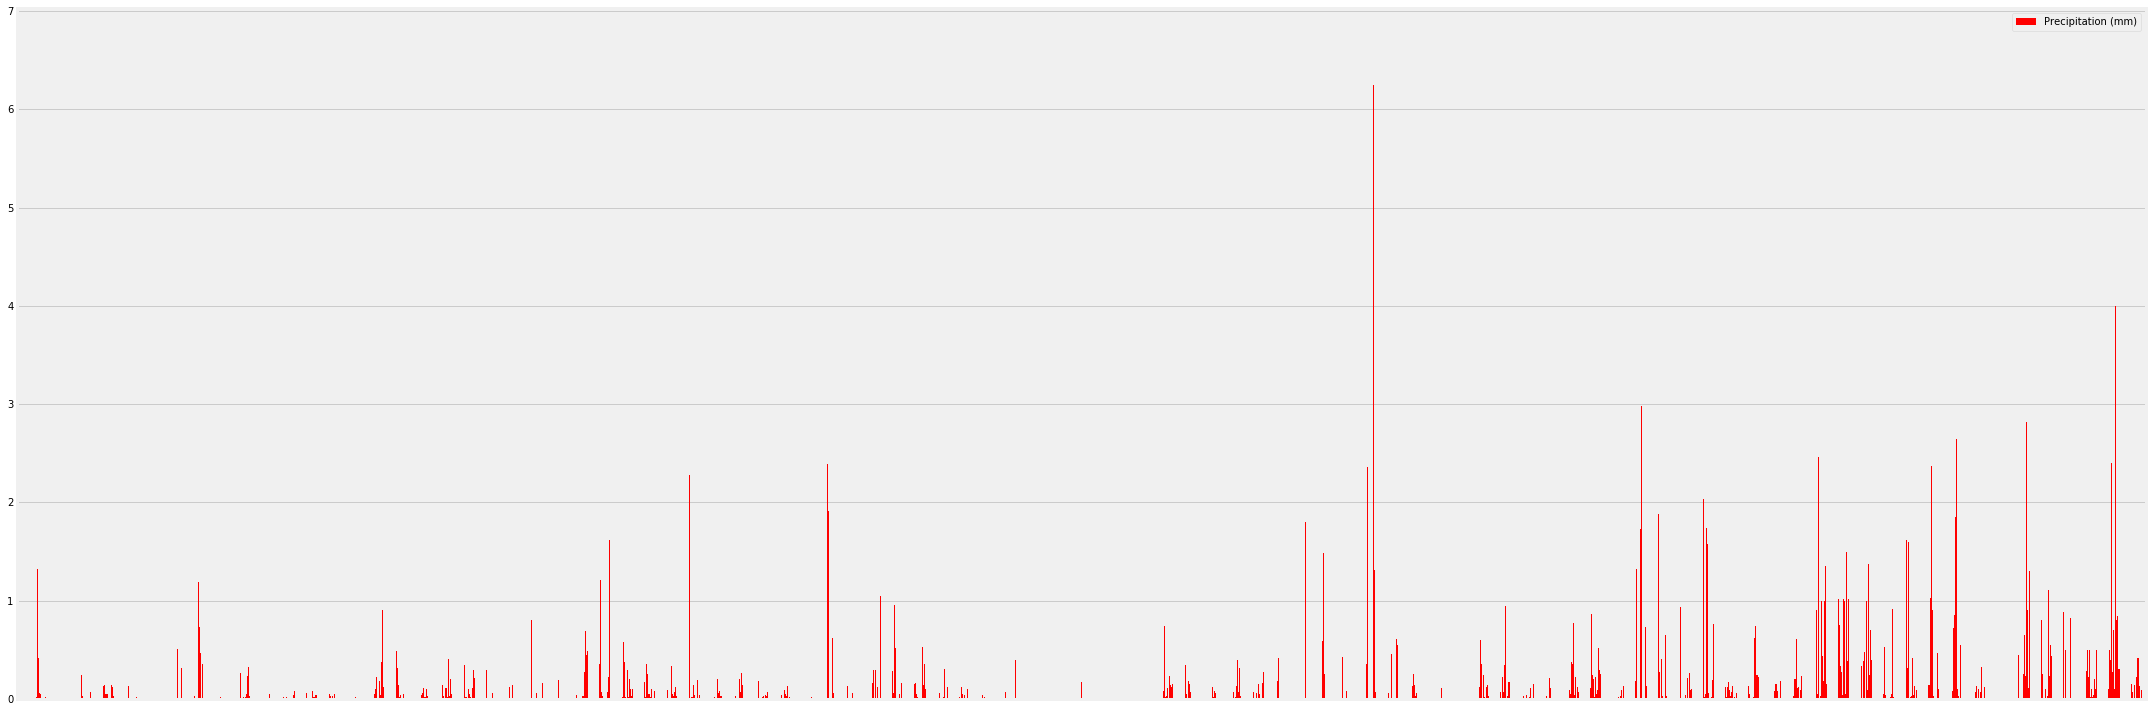

In [16]:
# Plot query
plot1 = prcp_12mo_df_idx.plot(kind='bar', y='Precipitation (mm)', color='red', figsize=(30,10))
plot1.axes.get_xaxis().set_visible(False)
plt.tight_layout()
plt.show()
# plt.savefig("Resources/test.jpeg")

![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_stat = prcp_12mo_df_idx['Precipitation (mm)'].describe()
prcp_stat

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation (mm), dtype: float64

![describe](Images/describe.png)

In [18]:
# Design a query to show how many stations are available in this dataset?
station_total = session.query(Measurement.station.distinct()).count()
print(f'The total number of stations in this dataset is {station_total}')

The total number of stations in this dataset is 9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = (session.query(Measurement.station, func.count(Measurement.station))).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_count


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_max = (session.query(Measurement.station, func.max(Measurement.tobs))).filter(Measurement.station == 'USC00519281').all()
# station_max

station_min = (session.query(Measurement.station, func.min(Measurement.tobs))).filter(Measurement.station == 'USC00519281').all()
# station_min

station_avg = (session.query(Measurement.station, func.avg(Measurement.tobs))).filter(Measurement.station == 'USC00519281').all()
# station_avg

print(f'The highest temperature recorded by the most active station: {station_max}')
print(f'The lowest temperature recorded by the most active station: {station_min}')
print(f'The average temperature recorded by the most active station: {station_avg}')

The highest temperature recorded by the most active station: [('USC00519281', 85.0)]
The lowest temperature recorded by the most active station: [('USC00519281', 54.0)]
The average temperature recorded by the most active station: [('USC00519281', 71.66378066378067)]


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(Measurement.station, Measurement.date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).first()

('USC00519281', '2017-08-18')

In [23]:
# Dates for the last 12 months 
query_date_2 = dt.date(2017, 8, 18) - dt.timedelta(days=365)

# Execute Query
tobs_12mo = session.query(Measurement.date, Measurement.tobs, Measurement.station).filter(Measurement.date > query_date_2).filter(Measurement.station == 'USC00519281').all()
tobs_12mo

[('2016-08-19', 79.0, 'USC00519281'),
 ('2016-08-20', 81.0, 'USC00519281'),
 ('2016-08-21', 79.0, 'USC00519281'),
 ('2016-08-22', 78.0, 'USC00519281'),
 ('2016-08-23', 77.0, 'USC00519281'),
 ('2016-08-24', 77.0, 'USC00519281'),
 ('2016-08-25', 80.0, 'USC00519281'),
 ('2016-08-26', 80.0, 'USC00519281'),
 ('2016-08-27', 75.0, 'USC00519281'),
 ('2016-08-28', 73.0, 'USC00519281'),
 ('2016-08-29', 78.0, 'USC00519281'),
 ('2016-08-30', 77.0, 'USC00519281'),
 ('2016-08-31', 78.0, 'USC00519281'),
 ('2016-09-01', 80.0, 'USC00519281'),
 ('2016-09-02', 80.0, 'USC00519281'),
 ('2016-09-03', 78.0, 'USC00519281'),
 ('2016-09-04', 78.0, 'USC00519281'),
 ('2016-09-05', 78.0, 'USC00519281'),
 ('2016-09-06', 73.0, 'USC00519281'),
 ('2016-09-07', 74.0, 'USC00519281'),
 ('2016-09-08', 80.0, 'USC00519281'),
 ('2016-09-09', 79.0, 'USC00519281'),
 ('2016-09-10', 77.0, 'USC00519281'),
 ('2016-09-11', 80.0, 'USC00519281'),
 ('2016-09-12', 76.0, 'USC00519281'),
 ('2016-09-13', 79.0, 'USC00519281'),
 ('2016-09-1

In [24]:
tobs_12mo_df = pd.DataFrame(tobs_12mo)
tobs_12mo_df

,date,tobs,station
0,2016-08-19,79.0,USC00519281
1,2016-08-20,81.0,USC00519281
2,2016-08-21,79.0,USC00519281
3,2016-08-22,78.0,USC00519281
4,2016-08-23,77.0,USC00519281
...,...,...,...
351,2017-08-14,77.0,USC00519281
352,2017-08-15,77.0,USC00519281
353,2017-08-16,76.0,USC00519281
354,2017-08-17,76.0,USC00519281


In [ ]:
# plot




n_bins = 20

# Generate a normal distribution, center at x=0 and y=5
x = len(tobs_12mo_df)
y = tobs_12mo_df['tobs']

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x, bins=n_bins)
axs[1].hist(y, bins=n_bins)



![precipitation](Images/station-histogram.png)

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [38]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_prcp = session.query(func.count(Measurement.prcp), Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).filter(Measurement.date > '2012-02-28').filter(Measurement.date < '2012-03-28').group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()
total_prcp

[(252, 'USC00519523', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (252, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (252, 'USC00519281', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (252, 'USC00516128', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (252, 'USC00513117', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (252, 'USC00511918', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (135, 'USC00514830', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (36, 'USC00518838', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (18, 'USC00517948', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

In [43]:
# Join the dbs on station code

joint_dbs = session.query(Measurement.station,
                         Measurement.prcp,
                         Measurement.tobs,
                         Measurement.id,
                         Measurement.date,
                         Station.latitude,
                         Station.elevation,
                         Station.longitude,
                         Station.id,
                         Station.station,
                         Station.name).join(Station, Measurement.station == Station.station).all()

type(joint_dbs)

list

In [48]:
for m, s in session.query(Measurement, Station, ).filter(Measurement.station == Station.station).filter(Measurement.date > '2012-02-28').filter(Measurement.date < '2012-03-28').group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all():
   print ("Total amount of rainfall: {} Station: {} Name: {} Latitude: {} Longitude: {} Elevation: {}".format(func.count(m.prcp),m.station, s.name, s.latitude, s.longitude, s.elevation))

Total amount of rainfall: count(:count_1) Station: USC00519523 Name: WAIMANALO EXPERIMENTAL FARM, HI US Latitude: 21.33556 Longitude: -157.71139 Elevation: 19.5
Total amount of rainfall: count(:count_1) Station: USC00519397 Name: WAIKIKI 717.2, HI US Latitude: 21.2716 Longitude: -157.8168 Elevation: 3.0
Total amount of rainfall: count(:count_1) Station: USC00519281 Name: WAIHEE 837.5, HI US Latitude: 21.45167 Longitude: -157.84888999999998 Elevation: 32.9
Total amount of rainfall: count(:count_1) Station: USC00516128 Name: MANOA LYON ARBO 785.2, HI US Latitude: 21.3331 Longitude: -157.8025 Elevation: 152.4
Total amount of rainfall: count(:count_1) Station: USC00513117 Name: KANEOHE 838.1, HI US Latitude: 21.4234 Longitude: -157.8015 Elevation: 14.6
Total amount of rainfall: count(:count_1) Station: USC00511918 Name: HONOLULU OBSERVATORY 702.2, HI US Latitude: 21.3152 Longitude: -157.9992 Elevation: 0.9
Total amount of rainfall: count(:count_1) Station: USC00514830 Name: KUALOA RANCH HE

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
